# 1. Population Distribution
# 2. Do Families Differ at All?
# 3. 70+ Binomial Screen in 10 unit intervals
# 4. 70- Binomial Screen in 10 unit intervals


# 
This cell imports the required libraries (psycopg2 for database access and pandas for data handling) and opens connection to the keeneland_yrlg_22 database. All subsequent data queries in the notebook depend on this connection.

In [1]:

import psycopg2
import pandas as pd

conn = psycopg2.connect(
    dbname="keeneland_yrlg_22",
    user="jackattack_user",
    password="Iam1ru12?",
    host="localhost",
    port=5432
)


## Verify Database Context

This cell confirms that the notebook is connected to the intended PostgreSQL database by reporting the active database, user, schema, and server version. This ensures all subsequent queries are run against the correct environment.


In [2]:
import pandas as pd

pd.read_sql("""
SELECT
  current_database() AS db,
  current_user AS usr,
  current_schema() AS schema,
  version() AS pg_version;
""", conn)


/tmp/ipykernel_264395/3407566580.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql("""


,db,usr,schema,pg_version
0,keeneland_yrlg_22,jackattack_user,public,PostgreSQL 16.11 (Ubuntu 16.11-0ubuntu0.24.04....


## Load and Join Core Dataset

This cell pulls the core analysis dataset by joining speed figures with female family numbers at the horse–sire level. It then runs basic sanity checks to confirm row counts, uniqueness of horses, and the presence of any missing family assignments.


## Split Known vs Missing Family Assignments

This cell separates horses with identified female family numbers from those without. Only horses with known family assignments are used in family-level analysis, while missing-family records are quarantined for transparency and potential follow-up.


In [5]:
import pandas as pd

query = """
SELECT
  s.horse_name,
  s.sire_name,
  s.speed_figure,
  h.family_number
FROM public.equibase_speed_2021_crop s
JOIN public.horse_familynumbers_crop_2021 h
  ON s.horse_name = h.horse_name
 AND s.sire_name  = h.sire_name;
"""
df = pd.read_sql(query, conn)

# Sanity checks
print("Rows:", len(df))
print("Unique horses:", df[['horse_name','sire_name']].drop_duplicates().shape[0])
print("Null families:", df['family_number'].isna().sum())



/tmp/ipykernel_264395/4049999093.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Rows: 13922
Unique horses: 13922
Null families: 1


In [ ]:
df_known = df[df['family_number'].notna()].copy()
df_missing = df[df['family_number'].isna()].copy()

print("Known families:", len(df_known))
print("Missing families:", len(df_missing))


Known families: 13921
Missing families: 1


In [6]:
import numpy as np
import pandas as pd
from scipy import stats

# -------------------------------------------------------------------
# CANONICAL PIPELINE (ONE PLACE TO DEFINE DATASETS)
# -------------------------------------------------------------------
# df = your joined dataset already loaded with columns:
#   horse_name, sire_name, speed_figure, family_number

# 0) Make speed_figure numeric (bad strings -> NaN)
df["speed_figure"] = pd.to_numeric(df["speed_figure"], errors="coerce")

# 1) Quarantine missing families (do NOT delete them from df)
df_missing_fam = df[df["family_number"].isna()].copy()
df_fam = df[df["family_number"].notna()].copy()          # only horses with known family numbers

# 2) Quarantine missing speed figures (only for tests that require numeric values)
df_fam_sf = df_fam[df_fam["speed_figure"].notna()].copy() # known family + observed speed figure

print("="*80)
print("DATA STATUS")
print("="*80)
print(f"All joined rows (df):               {len(df):,}")
print(f"Missing family quarantined:         {len(df_missing_fam):,}")
print(f"Known family (df_fam):              {len(df_fam):,}")
print(f"Known family + speed observed:      {len(df_fam_sf):,}")
print(f"NaNs in df_fam_sf.speed_figure:     {df_fam_sf['speed_figure'].isna().sum()}")

# -------------------------------------------------------------------
# BASELINES (use df_fam_sf so denominators match what is measurable)
# -------------------------------------------------------------------
total = len(df_fam_sf)
a80 = ((df_fam_sf["speed_figure"] >= 80) & (df_fam_sf["speed_figure"] < 100)).sum()
g100 = ((df_fam_sf["speed_figure"] >= 100) & (df_fam_sf["speed_figure"] < 110)).sum()
e110 = (df_fam_sf["speed_figure"] >= 110).sum()


base_a80  = a80  / total if total else np.nan
base_g100 = g100 / total if total else np.nan
base_e110 = e110 / total if total else np.nan


print("\n" + "="*80)
print("BASELINES (KNOWN FAMILY + OBSERVED SPEED)")
print("="*80)
print(f"Total horses: {total:,}")
print(f"Allowance 80+:  {a80:,} ({100*base_a80:.2f}%)")
print(f"Graded Stakes 100+: {g100:,} ({100*base_g100:.2f}%)")
print(f"Elite 110+:   {e110:,} ({100*base_e110:.2f}%)")


# -------------------------------------------------------------------
# FAMILY SUMMARY (computed on df_fam_sf so rates are well-defined)
# -------------------------------------------------------------------
fam = df_fam_sf.groupby("family_number").agg(
    n=("speed_figure", "size"),
    avg_speed=("speed_figure", "mean"),
    var_speed=("speed_figure", "var"),
    allowance_rate=("speed_figure", lambda x: (x >= 80).mean()),
    graded_stakes_rate=("speed_figure",   lambda x: (x >= 100).mean()),
    elite_rate=("speed_figure",   lambda x: (x >= 110).mean()),
).reset_index()

fam30 = fam[fam["n"] >= 30].copy()

print("\n" + "="*80)
print("FAMILY COVERAGE (ON OBSERVED SPEED DATA)")
print("="*80)
print(f"Families total:     {len(fam):,}")
print(f"Families with n>=30:{len(fam30):,}")

# -------------------------------------------------------------------
# ANOVA (means differ by family?) — now safe because df_fam_sf has no NaNs
# -------------------------------------------------------------------
families_30 = fam30["family_number"].tolist()
groups = [df_fam_sf.loc[df_fam_sf["family_number"] == f, "speed_figure"].values for f in families_30]

f_stat, p_value = stats.f_oneway(*groups)

print("\n" + "="*80)
print("ANOVA (speed_figure by family, n>=30)")
print("="*80)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value:     {p_value:.4g}")

# -------------------------------------------------------------------
# TOP vs BOTTOM 5 BY AVERAGE SPEED (n>=30)
# -------------------------------------------------------------------
fam30_sorted = fam30.sort_values("avg_speed", ascending=False)
top5 = fam30_sorted.head(5)["family_number"]
bot5 = fam30_sorted.tail(5)["family_number"]

top_speeds = df_fam_sf[df_fam_sf["family_number"].isin(top5)]["speed_figure"]
bot_speeds = df_fam_sf[df_fam_sf["family_number"].isin(bot5)]["speed_figure"]

t_stat, t_p = stats.ttest_ind(top_speeds, bot_speeds, equal_var=False)

print("\n" + "="*80)
print("TOP 5 vs BOTTOM 5 (by avg_speed, n>=30)")
print("="*80)
print(f"Top 5 mean speed:    {top_speeds.mean():.2f}")
print(f"Bottom 5 mean speed: {bot_speeds.mean():.2f}")
print(f"Difference:          {top_speeds.mean() - bot_speeds.mean():.2f}")
print(f"Welch t-test p:      {t_p:.2e}")

# -------------------------------------------------------------------
# LEADERS BY ELITE RATE (110+) and allowance RATE (95+) — n>=30
# -------------------------------------------------------------------
elite_leaders = fam30.sort_values(["elite_rate", "n"], ascending=[False, False]).head(20).copy()
elite_leaders["elite_rate_pct"] = 100 * elite_leaders["elite_rate"]
elite_leaders["elite_lift_pct_pts"] = 100 * (elite_leaders["elite_rate"] - base_e110)

allowance_leaders = fam30.sort_values(["allowance_rate", "n"], ascending=[False, False]).head(20).copy()
allowance_leaders["allowance_rate_pct"] = 100 * allowance_leaders["allowance_rate"]
allowance_leaders["allowance_lift_pct_pts"] = 100 * (allowance_leaders["allowance_rate"] - base_a80)

print("\n" + "="*80)
print("TOP FAMILIES BY ELITE RATE (110+) — n>=30")
print("="*80)
print(elite_leaders[["family_number","n","avg_speed","elite_rate_pct","elite_lift_pct_pts"]].round(2).to_string(index=False))

print("\n" + "="*80)
print("TOP FAMILIES BY allowance RATE (95+) — n>=30")
print("="*80)
print(allowance_leaders[["family_number","n","avg_speed","allowance_rate_pct","allowance_lift_pct_pts"]].round(2).to_string(index=False))



DATA STATUS
All joined rows (df):               13,922
Missing family quarantined:         1
Known family (df_fam):              13,921
Known family + speed observed:      13,920
NaNs in df_fam_sf.speed_figure:     0

BASELINES (KNOWN FAMILY + OBSERVED SPEED)
Total horses: 13,920
Allowance 80+:  4,910 (35.27%)
Graded Stakes 100+: 819 (5.88%)
Elite 110+:   156 (1.12%)

FAMILY COVERAGE (ON OBSERVED SPEED DATA)
Families total:     215
Families with n>=30:113

ANOVA (speed_figure by family, n>=30)
F-statistic: 1.1326
P-value:     0.161

TOP 5 vs BOTTOM 5 (by avg_speed, n>=30)
Top 5 mean speed:    79.50
Bottom 5 mean speed: 66.50
Difference:          12.99
Welch t-test p:      1.07e-11

TOP FAMILIES BY ELITE RATE (110+) — n>=30
family_number   n  avg_speed  elite_rate_pct  elite_lift_pct_pts
         10-d  47      74.64            8.51                7.39
          4-f  34      78.00            5.88                4.76
         22-b 141      73.85            5.67                4.55
       

## Population Speed Distribution

This cell visualizes the distribution of speed figures across all horses with known family and observed speed. It plots a histogram of speed figures, marks key performance thresholds (70, 95, 110), and overlays the population mean. The chart provides a visual baseline showing how horses are distributed across performance tiers before any family-level comparisons are made.



Max bar height: 1179.0
Min speed: 0.0
Max speed: 122.0


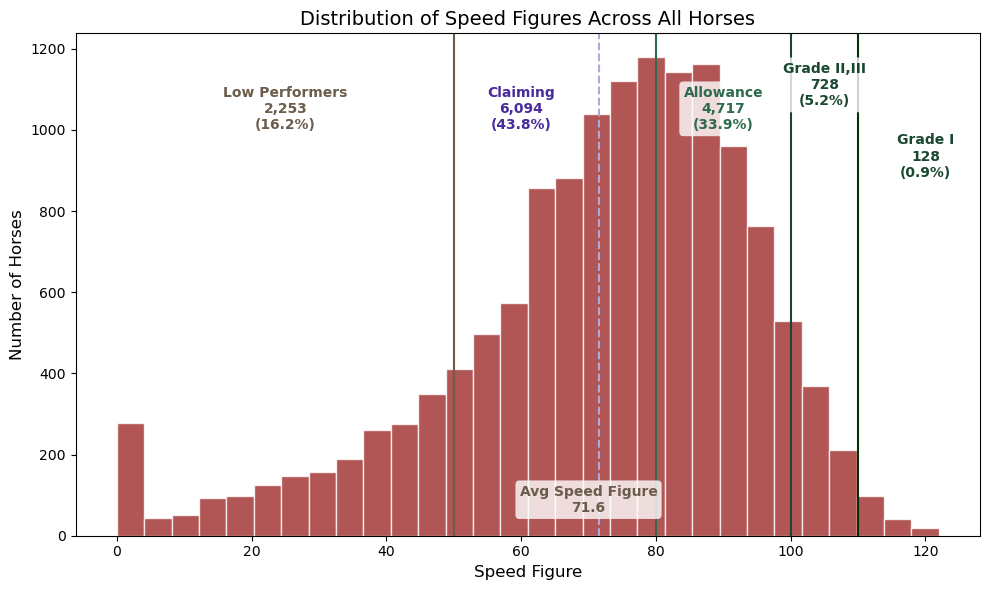

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get the counts
total = len(df_fam_sf)
low_performers = (df_fam_sf['speed_figure'] <= 50).sum()
pct_low_performers = 100 * low_performers / total

claiming = ((df_fam_sf['speed_figure'] > 50) & (df_fam_sf['speed_figure'] <= 80)).sum()
pct_claiming = 100 * claiming / total

allowance = ((df_fam_sf['speed_figure'] > 80) & (df_fam_sf['speed_figure'] <= 100)).sum()
pct_allowance = 100 * allowance / total

graded_stakes = ((df_fam_sf['speed_figure'] > 100) & (df_fam_sf['speed_figure'] <= 110)).sum()
pct_graded_stakes = 100 * graded_stakes / total

elite = (df_fam_sf['speed_figure'] > 110).sum()
pct_elite = 100 * elite / total

# Create histogram and capture the values
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_fam_sf['speed_figure'], bins=30, color='#9e2a2b', edgecolor='white', alpha=0.8)

print(f"Max bar height: {max(n)}")
print(f"Min speed: {df_fam_sf['speed_figure'].min()}")
print(f"Max speed: {df_fam_sf['speed_figure'].max()}")

mean_speed = df_fam_sf['speed_figure'].mean()

# Add vertical lines
plt.axvline(x=50, color='#6b5c4c', linestyle='-', linewidth=1.5)
plt.axvline(x=80, color='#2d6a4f', linestyle='-', linewidth=1.5)
plt.axvline(x=100, color='#1a4731', linestyle='-', linewidth=1.5)
plt.axvline(x=110, color="#083008", linestyle='-', linewidth=1.5)
plt.axvline(x=mean_speed, color="#b1a7df", linestyle='--', linewidth=1.5)


# Add annotations for each tier
max_height = max(n)
plt.text(25, max_height * 0.85, f'Low Performers\n{low_performers:,}\n({pct_low_performers:.1f}%)', 
         fontsize=10, fontweight='bold', color='#6b5c4c', ha='center')

plt.text(60, max_height * 0.85, f'Claiming\n{claiming:,}\n({pct_claiming:.1f}%)', 
         fontsize=10, fontweight='bold', color="#492a9e", ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(90, max_height * 0.85, f'Allowance\n{allowance:,}\n({pct_allowance:.1f}%)', 
         fontsize=10, fontweight='bold', color='#2d6a4f', ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(105, max_height * 0.90, f'Grade II,III\n{graded_stakes:,}\n({pct_graded_stakes:.1f}%)', 
         fontsize=10, fontweight='bold', color='#1a4731', ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(120, max_height * 0.75, f'Grade I\n{elite:,}\n({pct_elite:.1f}%)', 
         fontsize=10, fontweight='bold', color='#1a4731', ha='center')

plt.text(70, max_height * 0.05, f'Avg Speed Figure\n{mean_speed:.1f}', 
         fontsize=10, fontweight='bold', color='#6b5c4c', ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none'))

plt.xlabel('Speed Figure', fontsize=12)
plt.ylabel('Number of Horses', fontsize=12)
plt.title('Distribution of Speed Figures Across All Horses', fontsize=14)

plt.tight_layout()
plt.savefig('speed_distribution.png', dpi=150, facecolor='white')
plt.show()

#Binomial Test to Identify Families with Significant Overperformance in 10 unit Speed Tiers from 70 to 110+

In [8]:

from scipy.stats import binomtest

# --- settings ---
min_n = 30
alpha = 0.05
thresholds = list(range(70, 121, 10))  # 70,75,...,120  (change as you like)

# --- precompute family sizes once ---
fam_n = df_fam_sf.groupby("family_number")["speed_figure"].size().rename("n_total")
fam_n = fam_n[fam_n >= min_n]

rows = []
for t in thresholds:
    p_base = (df_fam_sf["speed_figure"] >= t).mean()  # population baseline at threshold t

    # count hits per family at threshold t
    hits = (df_fam_sf["speed_figure"] >= t).groupby(df_fam_sf["family_number"]).sum().rename("k_hits")
    tmp = pd.concat([fam_n, hits], axis=1).dropna()
    tmp["threshold"] = t
    tmp["p_base"] = p_base

    # binomial p-value (greater)
    tmp["p_value"] = tmp.apply(lambda r: 1.0 if r["k_hits"] == 0 else binomtest(int(r["k_hits"]), int(r["n_total"]), r["p_base"], alternative="greater").pvalue, axis=1)

    # useful columns
    tmp["rate"] = tmp["k_hits"] / tmp["n_total"]
    tmp["hit"] = tmp["p_value"] < alpha
    tmp["neglog10p"] = -np.log10(np.maximum(tmp["p_value"], 1e-300))

    rows.append(tmp.reset_index().rename(columns={"index": "family_number"}))

scan = pd.concat(rows, ignore_index=True)

# Quick summary: how many thresholds each family "hits"
hit_summary = (
    scan.groupby("family_number")
    .agg(
        n_thresholds_hit=("hit", "sum"),
        min_p_value=("p_value", "min"),
        hit_thresholds=("threshold", lambda x: sorted(x[scan.loc[x.index, "hit"]]))
    )
    .sort_values("n_thresholds_hit", ascending=False)
)

hit_summary_filtered = hit_summary[(hit_summary["min_p_value"] < 0.04) & (hit_summary["n_thresholds_hit"] >= 2)]
hit_summary_filtered





,n_thresholds_hit,min_p_value,hit_thresholds
family_number,,,
9,5,0.005327,"[70, 80, 90, 100, 110]"
26,4,0.002037,"[70, 80, 90, 100]"
8-k,3,0.000141,"[70, 80, 90]"
9-h,3,0.001267,"[70, 80, 90]"
13,3,0.012652,"[70, 80, 100]"
6-a,2,0.014427,"[70, 80]"
4-g,2,0.030568,"[90, 120]"
4-f,2,0.024437,"[70, 80]"
5-e,2,0.022962,"[80, 90]"


Plotting Binomial Hits

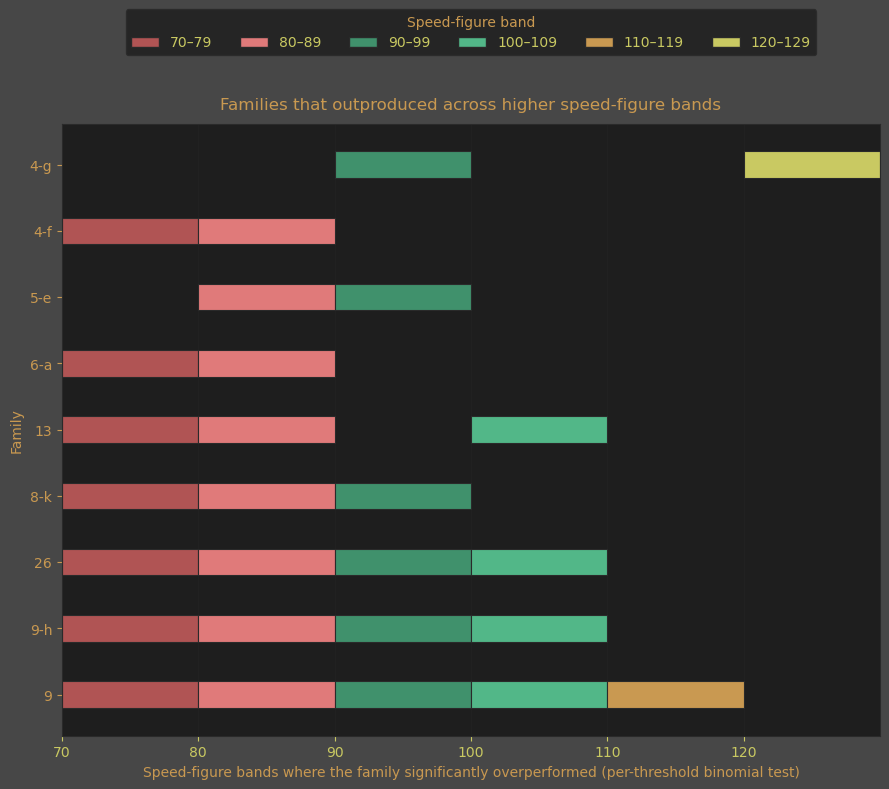

In [ ]:


# Assumes you already have: scan (long table with columns family_number, threshold, hit, p_value, etc.)
# and hit_summary_filtered (index=family_number with n_thresholds_hit, min_p_value, hit_thresholds)

# --- CSS color scheme (user-provided) ---
CSS = {
    "bg": "#121212c5",
    "text": "#c99951",
    "accent": "#c75d5dde",
    "accent_light": "#e07a7a",
    "muted": "#c9c962",
    "card_bg": "#1e1e1e",
    "border": "#2a2a2a",
    "highlight": "#2f2a1f86",
    "safe": "#40916c",
    "safe_light": "#52b788",
}

# --- pick which families to plot (filtered set, ordered by "strongest" first) ---
families = (
    hit_summary_filtered
    .sort_values(["n_thresholds_hit", "min_p_value"], ascending=[False, True])
    .index
    .tolist()
)

# Guard: nothing to plot
if len(families) == 0:
    raise ValueError("hit_summary_filtered is empty — no families passed your filter.")

# Derive thresholds & step from scan
thr_sorted = np.sort(scan["threshold"].unique())
if len(thr_sorted) < 2:
    raise ValueError("Need at least 2 thresholds to draw ranges (e.g., 70, 80, ...).")
step = int(thr_sorted[1] - thr_sorted[0])

# Build a hit matrix (family x threshold) for quick lookup
hit_mat = (
    scan.loc[scan["family_number"].isin(families), ["family_number", "threshold", "hit"]]
    .pivot_table(index="family_number", columns="threshold", values="hit", aggfunc="max")
    .fillna(False)
    .astype(bool)
)

# Color map for each threshold "band" [t, t+step)
# Reuse your palette, so every band has a consistent single color across families.
band_palette = [
    CSS["accent"], CSS["accent_light"], CSS["safe"], CSS["safe_light"],
    CSS["text"], CSS["muted"]
]
band_colors = {int(t): band_palette[i % len(band_palette)] for i, t in enumerate(thr_sorted)}

# --- Plot: each family on its own row; each "hit" band is a horizontal bar segment ---
fig, ax = plt.subplots(figsize=(11, max(3.5, 0.45 * len(families))))
fig.patch.set_facecolor(CSS["bg"])
ax.set_facecolor(CSS["card_bg"])

bar_height = 0.4
y_positions = np.arange(len(families))

for y, fam in zip(y_positions, families):
    for t in thr_sorted:
        if bool(hit_mat.loc[fam, t]) if t in hit_mat.columns else False:
            ax.broken_barh([(t, step)], (y - bar_height/2, bar_height),
                           facecolors=band_colors[int(t)], edgecolors=CSS["border"], linewidth=0.8)

# Axes styling
ax.set_yticks(y_positions)
ax.set_yticklabels([str(f) for f in families], color=CSS["text"])
ax.set_xlabel("Speed-figure bands where the family significantly overperformed (per-threshold binomial test)",
              color=CSS["text"])
ax.set_ylabel("Family", color=CSS["text"])

# x-axis ticks at thresholds
ax.set_xticks(thr_sorted)
ax.set_xlim(thr_sorted.min(), thr_sorted.max() + step)
ax.tick_params(axis="x", colors=CSS["muted"])
ax.tick_params(axis="y", colors=CSS["text"])

# Subtle grid (uses border color, not a new color)
ax.grid(True, axis="x", linewidth=0.6, alpha=0.35, color=CSS["border"])
ax.grid(False, axis="y")
fig.set_size_inches(9, 8)

# Spines
for spine in ax.spines.values():
    spine.set_color(CSS["border"])

# Legend: one entry per band
legend_handles = [Patch(facecolor=band_colors[int(t)], edgecolor=CSS["border"], label=f"{int(t)}–{int(t)+step-1}")
                  for t in thr_sorted]
leg = ax.legend(handles=legend_handles, title="Speed-figure band", ncol=6, frameon=True,
                bbox_to_anchor=(0.5, 1.1), loc="lower center")
leg.get_frame().set_facecolor(CSS["card_bg"])
leg.get_frame().set_edgecolor(CSS["border"])
plt.setp(leg.get_texts(), color=CSS["muted"])
plt.setp(leg.get_title(), color=CSS["text"])

ax.set_title("Families that outproduced across higher speed-figure bands",
             color=CSS["text"], pad=10)

plt.tight_layout()
plt.show()


#Binomial Test to Identify Families with Significant Overperformance in 10 unit Speed Tiers from 60 to 0.

In [ ]:
from scipy.stats import binomtest
import numpy as np
import pandas as pd

# --- settings ---
min_n = 30
alpha = 0.05
thresholds = list(range(60, -1, -10))   # 60, 50, 40, 30, 20, 10, 0  (edit as you like)

# --- precompute family sizes once ---
fam_n = df_fam_sf.groupby("family_number")["speed_figure"].size().rename("n_total")
fam_n = fam_n[fam_n >= min_n]

rows = []
for t in thresholds:
    # population baseline: fraction of ALL horses that are BELOW threshold t
    p_base = (df_fam_sf["speed_figure"] < t).mean()

    # count "low hits" per family: how many horses are BELOW threshold t
    low_hits = (df_fam_sf["speed_figure"] < t).groupby(df_fam_sf["family_number"]).sum().rename("k_low")
    tmp = pd.concat([fam_n, low_hits], axis=1).dropna()
    tmp["threshold"] = t
    tmp["p_base"] = p_base

    # binomial p-value: is this family producing TOO MANY lows (< t)?
    tmp["p_value"] = tmp.apply(
        lambda r: 1.0 if r["k_low"] == 0 else binomtest(
            int(r["k_low"]), int(r["n_total"]), r["p_base"], alternative="greater"
        ).pvalue,
        axis=1
    )

    # useful columns
    tmp["rate_low"] = tmp["k_low"] / tmp["n_total"]
    tmp["hit_low"] = tmp["p_value"] < alpha
    tmp["neglog10p"] = -np.log10(np.maximum(tmp["p_value"], 1e-300))

    rows.append(tmp.reset_index().rename(columns={"index": "family_number"}))

scan_low = pd.concat(rows, ignore_index=True)

# Quick summary: how many "low thresholds" each family hits
hit_summary_low = (
    scan_low.groupby("family_number")
    .agg(
        n_thresholds_hit=("hit_low", "sum"),
        min_p_value=("p_value", "min"),
        hit_thresholds=("threshold", lambda x: sorted(x[scan_low.loc[x.index, "hit_low"]]))
    )
    .sort_values(["n_thresholds_hit", "min_p_value"], ascending=[False, True])
)

hit_summary_low_filtered = hit_summary_low[
    (hit_summary_low["min_p_value"] < 0.04) & (hit_summary_low["n_thresholds_hit"] >= 2)
]

hit_summary_low_filtered


,n_thresholds_hit,min_p_value,hit_thresholds
family_number,,,
11-c,4,0.002721,"[10, 20, 30, 40]"
21-a,4,0.009495,"[10, 20, 30, 40]"
4-d,2,0.003584,"[20, 30]"
14-b,2,0.007931,"[30, 40]"
4-m,2,0.013155,"[50, 60]"
16-h,2,0.016875,"[10, 20]"


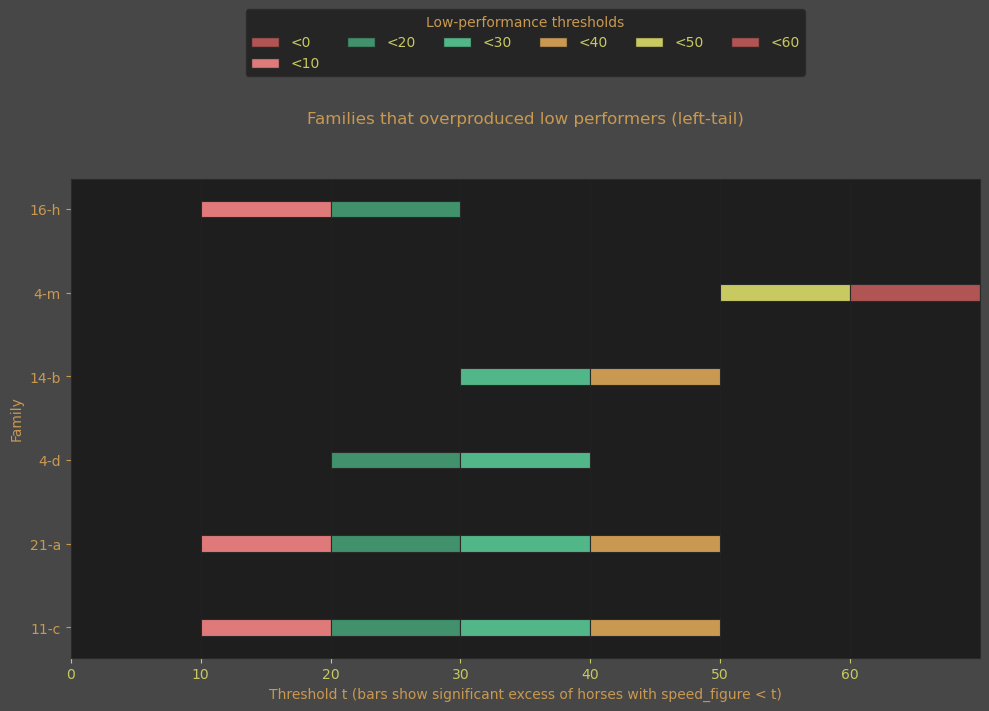

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- pick which families to plot ---
families = (
    hit_summary_low_filtered
    .sort_values(["n_thresholds_hit", "min_p_value"], ascending=[False, True])
    .index
    .tolist()
)

if len(families) == 0:
    raise ValueError("hit_summary_low_filtered is empty — no families passed your filter.")

# thresholds & step
thr_sorted = np.sort(scan_low["threshold"].unique())
if len(thr_sorted) < 2:
    raise ValueError("Need at least 2 thresholds (e.g., 60, 50, ...).")
step = int(abs(thr_sorted[1] - thr_sorted[0]))  # should be 10

# hit matrix (family x threshold)
hit_mat = (
    scan_low.loc[scan_low["family_number"].isin(families), ["family_number", "threshold", "hit_low"]]
    .pivot_table(index="family_number", columns="threshold", values="hit_low", aggfunc="max")
    .fillna(False)
    .astype(bool)
)

# color per band (consistent across families)
band_palette = [CSS["accent"], CSS["accent_light"], CSS["safe"], CSS["safe_light"], CSS["text"], CSS["muted"]]
band_colors = {int(t): band_palette[i % len(band_palette)] for i, t in enumerate(thr_sorted)}

# --- plot ---
fig, ax = plt.subplots(figsize=(11, max(3.5, 0.45 * len(families))))
fig.patch.set_facecolor(CSS["bg"])
ax.set_facecolor(CSS["card_bg"])
fig.set_size_inches(10, 5 + 0.4 * len(families))

bar_height = 0.2
y = np.arange(len(families))

for yi, fam in zip(y, families):
    for t in thr_sorted:
        if t in hit_mat.columns and bool(hit_mat.loc[fam, t]):
            ax.broken_barh([(t, step)], (yi - bar_height/2, bar_height),
                           facecolors=band_colors[int(t)],
                           edgecolors=CSS["border"], linewidth=0.8)

ax.set_yticks(y)
ax.set_yticklabels([str(f) for f in families], color=CSS["text"])

ax.set_xticks(thr_sorted)
ax.set_xlim(thr_sorted.min(), thr_sorted.max() + step)
ax.tick_params(axis="x", colors=CSS["muted"])
ax.tick_params(axis="y", colors=CSS["text"])

ax.grid(True, axis="x", linewidth=0.6, alpha=0.35, color=CSS["border"])
for spine in ax.spines.values():
    spine.set_color(CSS["border"])

legend_handles = [
    Patch(facecolor=band_colors[int(t)], edgecolor=CSS["border"], label=f"<{int(t)}")
    for t in thr_sorted
]
leg = ax.legend(handles=legend_handles, title="Low-performance thresholds", ncol=6, frameon=True,
                bbox_to_anchor=(0.5,1.2), loc="lower center")
leg.get_frame().set_facecolor(CSS["card_bg"])
leg.get_frame().set_edgecolor(CSS["border"])
plt.setp(leg.get_texts(), color=CSS["muted"])
plt.setp(leg.get_title(), color=CSS["text"])

ax.set_title("Families that overproduced low performers (left-tail)", color=CSS["text"], pad=40)
ax.set_xlabel("Threshold t (bars show significant excess of horses with speed_figure < t)", color=CSS["text"])
ax.set_ylabel("Family", color=CSS["text"])

plt.tight_layout()
plt.show()
